# 锂电池温度预测
锂离子电池材料的主要生产设备是电炉，研究烧结过程的数字化建模，通过电炉空间温度推测产品内部温度，设计烧结过程的温度场和浓度场的最优控制律，搭建产品制备过程运行平台，有望最终实现该过程的效率提升和协同优化，达到提高产品一致性，降低生产能耗的目标。初赛提供了电炉17个温区的实际生产数据，分别是电炉上部17组加热棒设定温度T1-1~T1-17，电炉下部17组加热棒设定温度T2-1~T2-17，底部17组进气口的设定进气流量V1-V17，选手需要根据提供的数据样本构建模型，预测电炉上下部空间17个测温点的测量温度值。初赛考核办法采用测试集各行数据的加热棒上部温度设定值、加热棒下部温度设定值、进气流量3类数据作为输入，选手分别预测上部空间测量温度、下部空间测量温度。将选手预测的上部空间测量温度、下部空间测量温度与测试集数据的测量值进行比较。采用MAE平均绝对误差作为评价指标。

## 环境配置

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import optuna
import optuna.visualization as ov
from optuna.exceptions import TrialPruned
from optuna.integration import LightGBMPruningCallback
from optuna.pruners import MedianPruner
from joblib import dump, load, Parallel, delayed
import numpy as np
from tqdm import tqdm

In [2]:
!pwd

/home/ubuntu


In [3]:
# !conda install pandas numpy scikit-learn lightgbm optuna joblib plotly nbformat kaleido  matplotlib -y
# m6x+T3HfZbGA[D aa71511fabbf4bc690fc9c6b871b71bb

## 参数配置

In [4]:

# 数据集路径
TRAIN_PATH = './datasets/train.csv'
TEST_PATH = './datasets/test.csv'
SUBMIT_PATH = './datasets/sample_submit.csv'

# 模型保存路径
MODEL_SAVE_PATH = './models'

# 文件输出路径
OUTPUT_PATH = './outputs'

# 使用的特征

USE_FEATURE_TYPES_ALL = ['timebase', 'statistical', 'overall', 'interaction', 'difference', 'ratio',
                         'rolling_window',
                         'spatial_gradient', 'time_gradient', 'time_spatial_gradient']

USE_FEATURE_TYPES = USE_FEATURE_TYPES_ALL

# 硬件配置
USE_CPU_CORES = 10

# 超参数配置
OPTUNA_ROUND = 50
TRAIN_ROUND = 5000
EARLY_STOPPING_ROUND = 20

# 日志级别
# optuna.logging.set_verbosity(optuna.logging.WARNING)

## 数据准备

In [5]:
# 数据提取
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# 重命名
df_train.columns = (
        ['index', 'datetime'] +
        [f'V{i + 1}' for i in range(17)] + [f'T1-{i + 1}' for i in range(17)] + [f'T2-{i + 1}' for i in range(17)] +
        [f'T1R-{i + 1}' for i in range(17)] + [f'T2R-{i + 1}' for i in range(17)]

)
df_test.columns = df_train.columns[:53]
df_train

index        datetime         V1         V2         V3         V4  \
0          1  2022/11/6 9:08  35.668999  36.146000  25.558001  26.195000   
1          2  2022/11/6 9:09  35.995998  36.347000  25.382000  26.348000   
2          3  2022/11/6 9:11  35.340000  36.311001  25.469999  26.093000   
3          4  2022/11/6 9:12  35.585999  36.091000  25.250000  26.127001   
4          5  2022/11/6 9:13  35.946999  36.256001  25.163000  26.399000   
...      ...             ...        ...        ...        ...        ...   
26651  26652   2023/3/1 3:49  24.594000  24.377001  29.191999  25.551001   
26652  26653   2023/3/1 3:54  24.379000  24.424999  29.253000  25.652000   
26653  26654   2023/3/1 4:00  24.407000  24.312000  29.010000  25.382000   
26654  26655   2023/3/1 4:05  24.636000  24.409000  29.162001  25.551001   
26655  26656   2023/3/1 4:10  24.236000  24.054001  28.874001  25.282000   

              V5      V6         V7      V8  ...  T2R-8  T2R-9  T2R-10  \
0      25.670000  15.702  16.690001  15.991  ...    827    827     827   
1      26.131001  15.523  16.825001  15.871  ...    827    827     827   
2      25.639000  15.564  15.564000  15.947  ...    827    827     827   
3      25.670000  15.575  16.775999  15.936  ...    827    827     827   
4      25.837999  15.460  16.580999  15.795  ...    827    827     827   
...          ...     ...        ...     ...  ...    ...    ...     ...   
26651  27.016001   4.377  21.929001  24.459  ...    837    837     837   
26652  27.188000   4.415  22.017000  24.534  ...    837    837     837   
26653  26.813000   4.354  21.726000  24.204  ...    837    837     837   
26654  27.032000   4.362  21.813000  21.813  ...    837    837     837   
26655  27.125000   4.384  21.944000  24.444  ...    837    837     837   

       T2R-11  T2R-12  T2R-13  T2R-14  T2R-15  T2R-16  T2R-17  
0         827     827     827     827     827     827     750  
1         827     827     827     827     827     827     750  
2         827     827     827     827     827     827     750  
3         827     827     827     827     827     827     750  
4         827     827     827     827     827     827     750  
...       ...     ...     ...     ...     ...     ...     ...  
26651     837     837     837     837     837     837     750  
26652     837     837     837     837     837     837     750  
26653     837     837     837     837     837     837     750  
26654     837     837     837     837     837     837     750  
26655     837     837     837     837     837     837     750  

[26656 rows x 87 columns]

In [14]:
df_test.shape

(11424, 53)

## 特征工程

In [15]:
def generate_features(df, feature_types: [str, ...]):
    df['timestamp'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('timestamp')

    # 时间特征-baseline
    if 'timebase' in feature_types:
        df['month'] = df['timestamp'].dt.month
        df['day'] = df['timestamp'].dt.day
        df['hour'] = df['timestamp'].dt.hour
        df['minute'] = df['timestamp'].dt.minute
        df['dayofweek'] = df['timestamp'].dt.dayofweek
        df["dayofyear"] = df["timestamp"].dt.dayofyear
        df["is_weekend"] = df["timestamp"].dt.dayofweek // 6
        df["weekofyear"] = df["timestamp"].dt.isocalendar().week.astype(int)

    # 时间特征
    if 'time' in feature_types:
        df['year'] = df['timestamp'].dt.year
        df['month'] = df['timestamp'].dt.month
        df['day'] = df['timestamp'].dt.day
        df['hour'] = df['timestamp'].dt.hour
        df['minute'] = df['timestamp'].dt.minute
        df['dayofweek'] = df['timestamp'].dt.dayofweek

    # 累积统计特征
    if 'statistical' in feature_types:
        for i in range(1, 18):
            df[f'T1-{i}_mean'] = df[[f'T1-{j}' for j in range(1, i + 1)]].mean(axis=1)
            df[f'T1-{i}_std'] = df[[f'T1-{j}' for j in range(1, i + 1)]].std(axis=1)

            df[f'T2-{i}_mean'] = df[[f'T2-{j}' for j in range(1, i + 1)]].mean(axis=1)
            df[f'T2-{i}_std'] = df[[f'T2-{j}' for j in range(1, i + 1)]].std(axis=1)

            df[f'V{i}_mean'] = df[[f'V{j}' for j in range(1, i + 1)]].mean(axis=1)
            df[f'V{i}_std'] = df[[f'V{j}' for j in range(1, i + 1)]].std(axis=1)

    # 上下温度区总体特征
    if 'overall' in feature_types:
        # Average, min, max, and standard deviation
        df['T1_mean'] = df[[f'T1-{i}' for i in range(1, 18)]].mean(axis=1)
        df['T1_min'] = df[[f'T1-{i}' for i in range(1, 18)]].min(axis=1)
        df['T1_max'] = df[[f'T1-{i}' for i in range(1, 18)]].max(axis=1)
        df['T1_std'] = df[[f'T1-{i}' for i in range(1, 18)]].std(axis=1)

        df['T2_mean'] = df[[f'T2-{i}' for i in range(1, 18)]].mean(axis=1)
        df['T2_min'] = df[[f'T2-{i}' for i in range(1, 18)]].min(axis=1)
        df['T2_max'] = df[[f'T2-{i}' for i in range(1, 18)]].max(axis=1)
        df['T2_std'] = df[[f'T2-{i}' for i in range(1, 18)]].std(axis=1)

        # Difference and ratio between upper and lower heating rods
        df['T1_T2_diff'] = df['T1_mean'] - df['T2_mean']
        df['T1_T2_ratio'] = df['T1_mean'] / df['T2_mean']

    # 上下温度区交互特征
    if 'interaction' in feature_types:
        for i in range(1, 18):
            df[f'T1-{i}_T2-{i}_diff'] = df[f'T1-{i}'] - df[f'T2-{i}']
            df[f'T1-{i}_T2-{i}_ratio'] = df[f'T1-{i}'] / df[f'T2-{i}']
            df[f'T1-{i}_T2-{i}_interaction'] = df[f'T1-{i}'] * df[f'T2-{i}']

    # 相邻数据点的差值
    if 'difference' in feature_types:
        for i in range(1, 17):
            df[f'T1-{i}_T1-{i + 1}_diff'] = df[f'T1-{i}'] - df[f'T1-{i + 1}']
            df[f'T2-{i}_T2-{i + 1}_diff'] = df[f'T2-{i}'] - df[f'T2-{i + 1}']
            df[f'V{i}_V{i + 1}_diff'] = df[f'V{i}'] - df[f'V{i + 1}']

    # 比例特征
    if 'ratio' in feature_types:
        for i in range(1, 18):
            df[f'T1-{i}_V{i}_ratio'] = df[f'T1-{i}'] / df[f'V{i}']
            df[f'T2-{i}_V{i}_ratio'] = df[f'T2-{i}'] / df[f'V{i}']
            df[f'T1-{i}_V{i}_interaction'] = df[f'T1-{i}'] * df[f'V{i}']
            df[f'T2-{i}_V{i}_interaction'] = df[f'T2-{i}'] * df[f'V{i}']

    # 滑动窗口特征
    if 'rolling_window' in feature_types:
        window_sizes = [i for i in range(1, 10)]  # TODO 调整
        for window_size in window_sizes:
            for i in range(1, 18):
                df[f'T1-{i}_rolling_mean_{window_size}'] = df[f'T1-{i}'].rolling(window_size).mean()
                df[f'T2-{i}_rolling_mean_{window_size}'] = df[f'T2-{i}'].rolling(window_size).mean()
                df[f'V{i}_rolling_mean_{window_size}'] = df[f'V{i}'].rolling(window_size).mean()

    # 空间梯度特征
    # 假设加热棒之间的空间距离是均匀的
    if 'spatial_gradient' in feature_types:
        for i in range(1, 17):
            df[f'T1-{i}_T1-{i + 1}_gradient'] = (df[f'T1-{i + 1}'] - df[f'T1-{i}']) / i
            df[f'T2-{i}_T2-{i + 1}_gradient'] = (df[f'T2-{i + 1}'] - df[f'T2-{i}']) / i

    # 时间梯度特征
    if 'time_gradient' in feature_types:
        for i in range(1, 18):
            df[f'T1-{i}_time_gradient'] = df[f'T1-{i}'].diff()
            df[f'T2-{i}_time_gradient'] = df[f'T2-{i}'].diff()
            df[f'V{i}_time_gradient'] = df[f'V{i}'].diff()

    # 时空梯度特征
    if 'time_spatial_gradient' in feature_types:
        for i in range(1, 17):
            df[f'T1-{i}_T1-{i + 1}_time_gradient'] = df[f'T1-{i + 1}'].diff() - df[f'T1-{i}'].diff()
            df[f'T2-{i}_T2-{i + 1}_time_gradient'] = df[f'T2-{i + 1}'].diff() - df[f'T2-{i}'].diff()
            df[f'V{i}_V{i + 1}_time_gradient'] = df[f'V{i + 1}'].diff() - df[f'V{i}'].diff()

    return df


df_add = generate_features(df_train.copy(), USE_FEATURE_TYPES)
df_add_test = generate_features(df_test.copy(), USE_FEATURE_TYPES)

df_add.columns

Index(['index', 'datetime', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
       'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'T1-1',
       'T1-2', 'T1-3', 'T1-4', 'T1-5', 'T1-6', 'T1-7', 'T1-8', 'T1-9', 'T1-10',
       'T1-11', 'T1-12', 'T1-13', 'T1-14', 'T1-15', 'T1-16', 'T1-17', 'T2-1',
       'T2-2', 'T2-3', 'T2-4', 'T2-5', 'T2-6', 'T2-7', 'T2-8', 'T2-9', 'T2-10',
       'T2-11', 'T2-12', 'T2-13', 'T2-14', 'T2-15', 'T2-16', 'T2-17', 'T1R-1',
       'T1R-2', 'T1R-3', 'T1R-4', 'T1R-5', 'T1R-6', 'T1R-7', 'T1R-8', 'T1R-9',
       'T1R-10', 'T1R-11', 'T1R-12', 'T1R-13', 'T1R-14', 'T1R-15', 'T1R-16',
       'T1R-17', 'T2R-1', 'T2R-2', 'T2R-3', 'T2R-4', 'T2R-5', 'T2R-6', 'T2R-7',
       'T2R-8', 'T2R-9', 'T2R-10', 'T2R-11', 'T2R-12', 'T2R-13', 'T2R-14',
       'T2R-15', 'T2R-16', 'T2R-17', 'timestamp', 'month', 'day', 'hour',
       'minute', 'dayofweek', 'dayofyear', 'is_weekend', 'weekofyear'],
      dtype='object')

## 训练前预处理

In [17]:
target_cols = df_add.columns[53: 53 + 17 * 2].tolist()
feature_cols = [col for col in df_add.columns if col not in target_cols + ['index', 'datetime', 'timestamp']]

# 训练集特征向量
X = df_add[feature_cols]

# 测试集特征向量
X_test = df_add_test[feature_cols]

# 训练集标签向量
Y = df_add[target_cols]

# 压缩数据
X = X.astype('float16')
X_test = X_test.astype('float16')

# TODO 压缩内存
X.shape, Y.shape, X_test.shape

((26656, 59), (26656, 34), (11424, 59))

## 模型训练

### 超参数优化

In [8]:
def objective(trial, x, y_target):
    """
    :param trial:
    :param x: n维特征向量
    :param y_target: 一维标签向量
    :return:
    """

    # 超参数范围
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression_l1',
            'metric': 'mae',
            'min_child_weight': 5,
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'seed': 2023,
            'nthread': USE_CPU_CORES,
            'verbose': -1,
            'early_stopping_round': EARLY_STOPPING_ROUND,
            # 正则化方法
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),
            'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
            'max_depth': trial.suggest_int('max_depth', -1, 50),
            # 剪枝
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 200),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.1, 1.0),

    }

    # 5-Fold 交叉验证进行训练
    train_data = lgb.Dataset(x, label=y_target)
    pruning_callback = LightGBMPruningCallback(trial, 'valid l1')
    cv_results = lgb.cv(params, train_data, num_boost_round=TRAIN_ROUND, nfold=5, callbacks=[pruning_callback])

    # 计算MAE
    mae = cv_results['valid l1-mean'][-1]
    return mae


### 多目标训练

[I 2023-07-22 16:51:07,613] A new study created in memory with name: no-name-f84fac44-0c7f-4073-a01a-7a96d0c093a0
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
[I 2023-07-22 16:51:27,107] Trial 0 finished with value: 4.8190556496436185 and parameters: {'num_leaves': 239, 'feature_fraction': 0.6827280285451528, 'bagging_fraction': 0.6161622157904738, 'bagging_freq': 4, 'learning_rate': 0.015084628292381398, 'lambda_l1': 7.251240326910576, 'lambda_l2': 8.981625416573092, 'min_split_gain': 0.007154387722458133, 'max_depth': 0, 'min_data_in_leaf': 71, 'min_gain_to_split': 0.7774294578322901}. Best is trial 0 with value: 4.8190556496436185.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which 

[LightGBM] [Warning] min_gain_to_split is set=0.28975594081296285, min_split_gain=0.33086061013987855 will be ignored. Current value: min_gain_to_split=0.28975594081296285
[LightGBM] [Warning] min_gain_to_split is set=0.28975594081296285, min_split_gain=0.33086061013987855 will be ignored. Current value: min_gain_to_split=0.28975594081296285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 295.722577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2023-07-22 16:57:28,523] A new study created in memory with name: no-name-1317d2be-b952-45db-bb8e-64c23f0bc163
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 16:57:32,054] Trial 0 finished with value: 4.633267516096773 and parameters: {'num_leaves': 228, 'feature_fraction': 0.47132397516236446, 'bagging_fraction': 0.9717515137301591, 'bagging_freq': 3, 'learning_rate': 0.07161428357121492, 'lambda_l1': 9.536257543332283, 'lambda_l2': 9.88471774939881, 'min_split_gain': 0.2981272498115579, 'max_depth': -1, 'min_data_in_leaf': 73, 'min_gain_to_split': 0.889021037847069}. Best is trial 0 with value: 4.633267516096773.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_spli

[LightGBM] [Warning] min_gain_to_split is set=0.11670740869826482, min_split_gain=0.9830101766314139 will be ignored. Current value: min_gain_to_split=0.11670740869826482
[LightGBM] [Warning] min_gain_to_split is set=0.11670740869826482, min_split_gain=0.9830101766314139 will be ignored. Current value: min_gain_to_split=0.11670740869826482
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 378.590674


[I 2023-07-22 17:01:31,336] A new study created in memory with name: no-name-b03896a5-b7c1-4650-89d9-82aaa8e31490
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:01:47,383] Trial 0 finished with value: 3.5853956042760884 and parameters: {'num_leaves': 256, 'feature_fraction': 0.5534645505881226, 'bagging_fraction': 0.5919732385483882, 'bagging_freq': 7, 'learning_rate': 0.010769617297548151, 'lambda_l1': 9.756676896887779, 'lambda_l2': 9.518320270711515, 'min_split_gain': 0.6652631011778847, 'max_depth': 12, 'min_data_in_leaf': 58, 'min_gain_to_split': 0.8779813222997009}. Best is trial 0 with value: 3.5853956042760884.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_

[LightGBM] [Warning] min_gain_to_split is set=0.5717500056379261, min_split_gain=0.15093606873834198 will be ignored. Current value: min_gain_to_split=0.5717500056379261
[LightGBM] [Warning] min_gain_to_split is set=0.5717500056379261, min_split_gain=0.15093606873834198 will be ignored. Current value: min_gain_to_split=0.5717500056379261
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 468.470138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2023-07-22 17:08:15,846] A new study created in memory with name: no-name-98f8ea15-922a-42d3-b263-89557c27d744
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:08:30,479] Trial 0 finished with value: 2.5871265862570896 and parameters: {'num_leaves': 49, 'feature_fraction': 0.6337562360896971, 'bagging_fraction': 0.6103498793181102, 'bagging_freq': 5, 'learning_rate': 0.018094374866728956, 'lambda_l1': 4.303968274291382, 'lambda_l2': 2.903954532620677, 'min_split_gain': 0.0917400998242962, 'max_depth': 27, 'min_data_in_leaf': 153, 'min_gain_to_split': 0.4829578524805678}. Best is trial 0 with value: 2.5871265862570896.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_

[LightGBM] [Warning] min_gain_to_split is set=0.294832874964171, min_split_gain=0.7690976388810022 will be ignored. Current value: min_gain_to_split=0.294832874964171
[LightGBM] [Warning] min_gain_to_split is set=0.294832874964171, min_split_gain=0.7690976388810022 will be ignored. Current value: min_gain_to_split=0.294832874964171
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 560.597276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2023-07-22 17:13:13,374] A new study created in memory with name: no-name-e7395ab0-d53d-4e91-a883-2303df9e9627
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:13:29,928] Trial 0 finished with value: 3.033660444741739 and parameters: {'num_leaves': 99, 'feature_fraction': 0.5961907986927264, 'bagging_fraction': 0.7885186544201557, 'bagging_freq': 6, 'learning_rate': 0.02290849821712368, 'lambda_l1': 3.26158507949746, 'lambda_l2': 6.802194005703338, 'min_split_gain': 0.43155553873265984, 'max_depth': 35, 'min_data_in_leaf': 191, 'min_gain_to_split': 0.58775512538903}. Best is trial 0 with value: 3.033660444741739.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_split

[LightGBM] [Warning] min_gain_to_split is set=0.1928191127085047, min_split_gain=0.8284045693430877 will be ignored. Current value: min_gain_to_split=0.1928191127085047
[LightGBM] [Warning] min_gain_to_split is set=0.1928191127085047, min_split_gain=0.8284045693430877 will be ignored. Current value: min_gain_to_split=0.1928191127085047
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 628.443015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-07-22 17:18:23,781] A new study created in memory with name: no-name-9fe492a1-e57d-409f-a798-36a9752ae7c5
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:18:37,810] Trial 0 finished with value: 2.4210905702527294 and parameters: {'num_leaves': 49, 'feature_fraction': 0.4528637387412818, 'bagging_fraction': 0.7412952798280743, 'bagging_freq': 2, 'learning_rate': 0.025615281330699267, 'lambda_l1': 3.5740137136806203, 'lambda_l2': 3.195142844315461, 'min_split_gain': 0.750451721612756, 'max_depth': 31, 'min_data_in_leaf': 70, 'min_gain_to_split': 0.760121033472484}. Best is trial 0 with value: 2.4210905702527294.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_sp

[LightGBM] [Warning] min_gain_to_split is set=0.3402817810748926, min_split_gain=0.8520129012439697 will be ignored. Current value: min_gain_to_split=0.3402817810748926
[LightGBM] [Warning] min_gain_to_split is set=0.3402817810748926, min_split_gain=0.8520129012439697 will be ignored. Current value: min_gain_to_split=0.3402817810748926
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 713.325893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-07-22 17:24:40,136] A new study created in memory with name: no-name-11a98f5b-bd1d-41a1-9987-ce85fb2f3054
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:24:58,609] Trial 0 finished with value: 1.5770265004907678 and parameters: {'num_leaves': 150, 'feature_fraction': 0.4346428863709202, 'bagging_fraction': 0.8065225390441038, 'bagging_freq': 3, 'learning_rate': 0.045402981159595436, 'lambda_l1': 8.122737482612765, 'lambda_l2': 4.312442714490104, 'min_split_gain': 0.17802234266429096, 'max_depth': 33, 'min_data_in_leaf': 160, 'min_gain_to_split': 0.20011983592024485}. Best is trial 0 with value: 1.5770265004907678.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than

[LightGBM] [Warning] min_gain_to_split is set=0.631293027288299, min_split_gain=0.10398092435364081 will be ignored. Current value: min_gain_to_split=0.631293027288299
[LightGBM] [Warning] min_gain_to_split is set=0.631293027288299, min_split_gain=0.10398092435364081 will be ignored. Current value: min_gain_to_split=0.631293027288299
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 793.986345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[I 2023-07-22 17:29:21,136] A new study created in memory with name: no-name-db700ca1-37e4-406b-a1f5-749f6d55cb75
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:29:35,131] Trial 0 finished with value: 0.28343227924001374 and parameters: {'num_leaves': 219, 'feature_fraction': 0.9555176653513365, 'bagging_fraction': 0.4655346457671595, 'bagging_freq': 6, 'learning_rate': 0.01486790480065752, 'lambda_l1': 4.097592365464503, 'lambda_l2': 9.58592689600467, 'min_split_gain': 0.1776457089778941, 'max_depth': 41, 'min_data_in_leaf': 141, 'min_gain_to_split': 0.793008575300299}. Best is trial 0 with value: 0.28343227924001374.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_

[LightGBM] [Warning] min_gain_to_split is set=0.793008575300299, min_split_gain=0.1776457089778941 will be ignored. Current value: min_gain_to_split=0.793008575300299
[LightGBM] [Warning] min_gain_to_split is set=0.793008575300299, min_split_gain=0.1776457089778941 will be ignored. Current value: min_gain_to_split=0.793008575300299
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 852.403436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2023-07-22 17:32:10,028] A new study created in memory with name: no-name-1e4af0bd-24d9-4472-b46f-e63b2f251da7


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stop

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:32:24,820] Trial 0 finished with value: 0.4729869441765212 and parameters: {'num_leaves': 230, 'feature_fraction': 0.4542024478566976, 'bagging_fraction': 0.6638627816002041, 'bagging_freq': 1, 'learning_rate': 0.04577270122757979, 'lambda_l1': 6.499587592734017, 'lambda_l2': 8.699576073267488, 'min_split_gain': 0.1226475865922888, 'max_depth': 26, 'min_data_in_leaf': 121, 'min_gain_to_split': 0.6056824850234417}. Best is trial 0 with value: 0.4729869441765212.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:32:45,502] Trial 1 finished with value: 2.632688742913894 and parameters: {'num_leaves

[LightGBM] [Warning] min_gain_to_split is set=0.4406573145263776, min_split_gain=0.8030915556553695 will be ignored. Current value: min_gain_to_split=0.4406573145263776
[LightGBM] [Warning] min_gain_to_split is set=0.4406573145263776, min_split_gain=0.8030915556553695 will be ignored. Current value: min_gain_to_split=0.4406573145263776
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 856.188138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-07-22 17:37:40,872] A new study created in memory with name: no-name-17081a9b-bf43-4afb-9811-445a0bfbca75


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:37:58,534] Trial 0 finished with value: 1.6983752610267786 and parameters: {'num_leaves': 123, 'feature_fraction': 0.6662957342163986, 'bagging_fraction': 0.7420049080904139, 'bagging_freq': 2, 'learning_rate': 0.01204507460520798, 'lambda_l1': 7.845173411770613, 'lambda_l2': 8.75829803799148, 'min_split_gain': 0.640624260668115, 'max_depth': 24, 'min_data_in_leaf': 130, 'min_gain_to_split': 0.1339409376546001}. Best is trial 0 with value: 1.6983752610267786.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:38:14,552] Trial 1 finished with value: 0.39332324347775127 and parameters: {'num_leaves

[LightGBM] [Warning] min_gain_to_split is set=0.576458924331614, min_split_gain=0.011016412061074256 will be ignored. Current value: min_gain_to_split=0.576458924331614
[LightGBM] [Warning] min_gain_to_split is set=0.576458924331614, min_split_gain=0.011016412061074256 will be ignored. Current value: min_gain_to_split=0.576458924331614
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 856.186112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-07-22 17:42:34,406] A new study created in memory with name: no-name-3520f410-49f4-4dde-8bec-90db521355c4
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:42:46,162] Trial 0 finished with value: 0.8655353970711763 and parameters: {'num_leaves': 67, 'feature_fraction': 0.8823356766152542, 'bagging_fraction': 0.5134291695521775, 'bagging_freq': 4, 'learning_rate': 0.031954950112480215, 'lambda_l1': 7.079273334004153, 'lambda_l2': 2.978776410030334, 'min_split_gain': 0.44449842165553966, 'max_depth': 9, 'min_data_in_leaf': 163, 'min_gain_to_split': 0.52606332458795}. Best is trial 0 with value: 0.8655353970711763.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_sp

[LightGBM] [Warning] min_gain_to_split is set=0.8824156043023024, min_split_gain=0.6164692515783442 will be ignored. Current value: min_gain_to_split=0.8824156043023024
[LightGBM] [Warning] min_gain_to_split is set=0.8824156043023024, min_split_gain=0.6164692515783442 will be ignored. Current value: min_gain_to_split=0.8824156043023024
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 854.718712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-07-22 17:46:08,945] A new study created in memory with name: no-name-56d2d834-1d4e-446b-ade1-87734ae499a5


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:46:25,390] Trial 0 finished with value: 0.5891114355155056 and parameters: {'num_leaves': 252, 'feature_fraction': 0.7489589066875534, 'bagging_fraction': 0.6352192915230974, 'bagging_freq': 6, 'learning_rate': 0.0723674759352468, 'lambda_l1': 3.7350831033393606, 'lambda_l2': 2.477191808812802, 'min_split_gain': 0.37438033447144503, 'max_depth': 18, 'min_data_in_leaf': 146, 'min_gain_to_split': 0.6704493862214312}. Best is trial 0 with value: 0.5891114355155056.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:46:32,445] Trial 1 finished with value: 0.6530310707852371 and parameters: {'num_leav

[LightGBM] [Warning] min_gain_to_split is set=0.853143581895051, min_split_gain=0.7285214644486209 will be ignored. Current value: min_gain_to_split=0.853143581895051
[LightGBM] [Warning] min_gain_to_split is set=0.853143581895051, min_split_gain=0.7285214644486209 will be ignored. Current value: min_gain_to_split=0.853143581895051
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 853.374850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2023-07-22 17:50:07,097] A new study created in memory with name: no-name-852a7be3-7cd3-4217-8310-f79278e63a1e


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:50:24,811] Trial 0 finished with value: 13.048884964823458 and parameters: {'num_leaves': 209, 'feature_fraction': 0.6563254550134725, 'bagging_fraction': 0.5876165567035564, 'bagging_freq': 5, 'learning_rate': 0.05231309048889696, 'lambda_l1': 2.451406812219419, 'lambda_l2': 3.8234992502783696, 'min_split_gain': 0.24619570863734153, 'max_depth': 11, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.16676203075917811}. Best is trial 0 with value: 13.048884964823458.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:50:31,297] Trial 1 finished with value: 6.762228153701154 and parameters: {'num_leav

[LightGBM] [Warning] min_gain_to_split is set=0.10378654985569452, min_split_gain=0.4481477108154468 will be ignored. Current value: min_gain_to_split=0.10378654985569452
[LightGBM] [Warning] min_gain_to_split is set=0.10378654985569452, min_split_gain=0.4481477108154468 will be ignored. Current value: min_gain_to_split=0.10378654985569452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 852.162327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-07-22 17:55:18,064] A new study created in memory with name: no-name-049c46a7-37af-4a2b-abf1-912be5d1e9d3


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:55:31,406] Trial 0 finished with value: 2.2534633038993412 and parameters: {'num_leaves': 54, 'feature_fraction': 0.8833485915369502, 'bagging_fraction': 0.7225317819422499, 'bagging_freq': 6, 'learning_rate': 0.08010763538210679, 'lambda_l1': 9.6116793742802, 'lambda_l2': 0.8297644845062402, 'min_split_gain': 0.19064526599684128, 'max_depth': 45, 'min_data_in_leaf': 48, 'min_gain_to_split': 0.9469169691362634}. Best is trial 0 with value: 2.2534633038993412.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:55:51,559] Trial 1 finished with value: 3.322666419664683 and parameters: {'num_leaves':

[LightGBM] [Warning] min_gain_to_split is set=0.2279091253390145, min_split_gain=0.16981871700408624 will be ignored. Current value: min_gain_to_split=0.2279091253390145
[LightGBM] [Warning] min_gain_to_split is set=0.2279091253390145, min_split_gain=0.16981871700408624 will be ignored. Current value: min_gain_to_split=0.2279091253390145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 850.903962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2023-07-22 17:57:06,432] A new study created in memory with name: no-name-72ec1c7e-1057-429b-8fab-fcf76f18f571
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 17:57:24,055] Trial 0 finished with value: 11.224665567124784 and parameters: {'num_leaves': 118, 'feature_fraction': 0.6125497535189202, 'bagging_fraction': 0.4034109457924904, 'bagging_freq': 6, 'learning_rate': 0.033751167708991746, 'lambda_l1': 4.137760085736378, 'lambda_l2': 9.820859305715755, 'min_split_gain': 0.4233022556316941, 'max_depth': 47, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.7361292597515514}. Best is trial 0 with value: 11.224665567124784.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_

[LightGBM] [Warning] min_gain_to_split is set=0.44418873205451703, min_split_gain=0.1149978749594579 will be ignored. Current value: min_gain_to_split=0.44418873205451703
[LightGBM] [Warning] min_gain_to_split is set=0.44418873205451703, min_split_gain=0.1149978749594579 will be ignored. Current value: min_gain_to_split=0.44418873205451703
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 850.026373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-07-22 17:59:58,145] A new study created in memory with name: no-name-64c99b52-0543-4949-9cdd-2a8f8754e6b3
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:00:04,313] Trial 0 finished with value: 0.7682882081402346 and parameters: {'num_leaves': 173, 'feature_fraction': 0.9971766370310492, 'bagging_fraction': 0.48413549302282144, 'bagging_freq': 7, 'learning_rate': 0.053007488456322936, 'lambda_l1': 8.432887215366554, 'lambda_l2': 1.6622723782734306, 'min_split_gain': 0.48410257279699875, 'max_depth': 3, 'min_data_in_leaf': 121, 'min_gain_to_split': 0.738435791819016}. Best is trial 0 with value: 0.7682882081402346.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than 

[LightGBM] [Warning] min_gain_to_split is set=0.16662147472881036, min_split_gain=0.920016815461869 will be ignored. Current value: min_gain_to_split=0.16662147472881036
[LightGBM] [Warning] min_gain_to_split is set=0.16662147472881036, min_split_gain=0.920016815461869 will be ignored. Current value: min_gain_to_split=0.16662147472881036
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 845.868923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2023-07-22 18:02:57,498] A new study created in memory with name: no-name-3b0db261-4901-4185-9d5d-dbb727e3b3c4
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:03:10,170] Trial 0 finished with value: 1.0474202789593892 and parameters: {'num_leaves': 189, 'feature_fraction': 0.7709427244920085, 'bagging_fraction': 0.43728412434472347, 'bagging_freq': 1, 'learning_rate': 0.011902657526162291, 'lambda_l1': 8.580392948730667, 'lambda_l2': 5.991860851342, 'min_split_gain': 0.6545968626093119, 'max_depth': -1, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.49335662540256564}. Best is trial 0 with value: 1.0474202789593892.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_s

[LightGBM] [Warning] min_gain_to_split is set=0.39245729654518535, min_split_gain=0.7886829753118165 will be ignored. Current value: min_gain_to_split=0.39245729654518535
[LightGBM] [Warning] min_gain_to_split is set=0.39245729654518535, min_split_gain=0.7886829753118165 will be ignored. Current value: min_gain_to_split=0.39245729654518535
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 765.929284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-07-22 18:07:13,720] A new study created in memory with name: no-name-bcc6c747-3c1c-4bde-a85d-b2a852c6ecbb
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:07:34,000] Trial 0 finished with value: 3.2331701417633583 and parameters: {'num_leaves': 155, 'feature_fraction': 0.911784634629409, 'bagging_fraction': 0.9464965777553387, 'bagging_freq': 1, 'learning_rate': 0.08177645930520218, 'lambda_l1': 3.8216641276659793, 'lambda_l2': 8.697602493617534, 'min_split_gain': 0.11038958302921942, 'max_depth': 38, 'min_data_in_leaf': 172, 'min_gain_to_split': 0.35862043056542703}. Best is trial 0 with value: 3.2331701417633583.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than 

[LightGBM] [Warning] min_gain_to_split is set=0.8746087391921149, min_split_gain=0.7349854429480003 will be ignored. Current value: min_gain_to_split=0.8746087391921149
[LightGBM] [Warning] min_gain_to_split is set=0.8746087391921149, min_split_gain=0.7349854429480003 will be ignored. Current value: min_gain_to_split=0.8746087391921149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 229.851028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-07-22 18:09:33,096] A new study created in memory with name: no-name-adeefc9d-763f-45bf-97da-8df924d76d6a
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:09:54,035] Trial 0 finished with value: 1.8629898877139635 and parameters: {'num_leaves': 201, 'feature_fraction': 0.5682340854473998, 'bagging_fraction': 0.8006566730762359, 'bagging_freq': 2, 'learning_rate': 0.01854479206366079, 'lambda_l1': 6.176227572142059, 'lambda_l2': 4.614080008057417, 'min_split_gain': 0.5094481373670193, 'max_depth': 44, 'min_data_in_leaf': 107, 'min_gain_to_split': 0.6641914013039186}. Best is trial 0 with value: 1.8629898877139635.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_

[LightGBM] [Warning] min_gain_to_split is set=0.5063959059495835, min_split_gain=0.0009321832018078791 will be ignored. Current value: min_gain_to_split=0.5063959059495835
[LightGBM] [Warning] min_gain_to_split is set=0.5063959059495835, min_split_gain=0.0009321832018078791 will be ignored. Current value: min_gain_to_split=0.5063959059495835
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 338.083283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2023-07-22 18:15:01,908] A new study created in memory with name: no-name-ab60dcc9-66d3-4934-9306-29a6ead91f63
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:15:23,721] Trial 0 finished with value: 0.770075809416831 and parameters: {'num_leaves': 211, 'feature_fraction': 0.8908711677390919, 'bagging_fraction': 0.8479683244085363, 'bagging_freq': 1, 'learning_rate': 0.053721100485998076, 'lambda_l1': 5.80856698003105, 'lambda_l2': 5.380025981048705, 'min_split_gain': 0.2279748722079683, 'max_depth': 15, 'min_data_in_leaf': 106, 'min_gain_to_split': 0.15232914645087134}. Best is trial 0 with value: 0.770075809416831.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_s

[LightGBM] [Warning] min_gain_to_split is set=0.10745307994760375, min_split_gain=0.00213794944883426 will be ignored. Current value: min_gain_to_split=0.10745307994760375
[LightGBM] [Warning] min_gain_to_split is set=0.10745307994760375, min_split_gain=0.00213794944883426 will be ignored. Current value: min_gain_to_split=0.10745307994760375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 443.733456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2023-07-22 18:21:55,308] A new study created in memory with name: no-name-1f42c0a1-5e53-415d-ac84-509a0157a33c
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:22:07,249] Trial 0 finished with value: 1.523708291137202 and parameters: {'num_leaves': 23, 'feature_fraction': 0.9663271649381928, 'bagging_fraction': 0.6681462491862933, 'bagging_freq': 5, 'learning_rate': 0.03375106466212367, 'lambda_l1': 6.710230313416771, 'lambda_l2': 9.331799422310498, 'min_split_gain': 0.046197367492529895, 'max_depth': 34, 'min_data_in_leaf': 101, 'min_gain_to_split': 0.29459786821553885}. Best is trial 0 with value: 1.523708291137202.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_

[LightGBM] [Warning] min_gain_to_split is set=0.459019036306454, min_split_gain=0.11250612732330867 will be ignored. Current value: min_gain_to_split=0.459019036306454
[LightGBM] [Warning] min_gain_to_split is set=0.459019036306454, min_split_gain=0.11250612732330867 will be ignored. Current value: min_gain_to_split=0.459019036306454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 550.252964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[I 2023-07-22 18:26:19,478] A new study created in memory with name: no-name-f00fef22-7941-4f8a-a644-a72a73080dc6
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:26:36,894] Trial 0 finished with value: 1.4016727655287855 and parameters: {'num_leaves': 118, 'feature_fraction': 0.8296059732596377, 'bagging_fraction': 0.8498054914453717, 'bagging_freq': 7, 'learning_rate': 0.059131798728096076, 'lambda_l1': 2.741313678830939, 'lambda_l2': 4.926851942664233, 'min_split_gain': 0.9670297258167314, 'max_depth': 29, 'min_data_in_leaf': 197, 'min_gain_to_split': 0.14941086399443895}. Best is trial 0 with value: 1.4016727655287855.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than 

[LightGBM] [Warning] min_gain_to_split is set=0.15952976016147108, min_split_gain=0.7562269239845704 will be ignored. Current value: min_gain_to_split=0.15952976016147108
[LightGBM] [Warning] min_gain_to_split is set=0.15952976016147108, min_split_gain=0.7562269239845704 will be ignored. Current value: min_gain_to_split=0.15952976016147108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 596.214998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-07-22 18:30:37,954] A new study created in memory with name: no-name-8a8a5d43-e76a-409e-b2e1-cfcdc2f8da34
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:30:57,356] Trial 0 finished with value: 0.757088650215546 and parameters: {'num_leaves': 239, 'feature_fraction': 0.5488280171732041, 'bagging_fraction': 0.5517693557192649, 'bagging_freq': 4, 'learning_rate': 0.042523738231919246, 'lambda_l1': 6.1345931609221, 'lambda_l2': 6.523896813304921, 'min_split_gain': 0.9980206267806331, 'max_depth': 32, 'min_data_in_leaf': 41, 'min_gain_to_split': 0.17720726790575947}. Best is trial 0 with value: 0.757088650215546.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_spl

[LightGBM] [Warning] min_gain_to_split is set=0.13418329985792, min_split_gain=0.9920009506377259 will be ignored. Current value: min_gain_to_split=0.13418329985792
[LightGBM] [Warning] min_gain_to_split is set=0.13418329985792, min_split_gain=0.9920009506377259 will be ignored. Current value: min_gain_to_split=0.13418329985792
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 691.752514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[I 2023-07-22 18:53:39,620] A new study created in memory with name: no-name-964b5b78-b83d-491e-8b90-fc5ade800864
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:53:54,566] Trial 0 finished with value: 0.863559485997605 and parameters: {'num_leaves': 103, 'feature_fraction': 0.7214232902267292, 'bagging_fraction': 0.5532297425411365, 'bagging_freq': 1, 'learning_rate': 0.0634090664160961, 'lambda_l1': 1.5761702196063787, 'lambda_l2': 5.511439988594198, 'min_split_gain': 0.20513784489990272, 'max_depth': 36, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.7925020931985854}. Best is trial 0 with value: 0.863559485997605.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_s

[LightGBM] [Warning] min_gain_to_split is set=0.631025408163027, min_split_gain=0.1182312976823604 will be ignored. Current value: min_gain_to_split=0.631025408163027
[LightGBM] [Warning] min_gain_to_split is set=0.631025408163027, min_split_gain=0.1182312976823604 will be ignored. Current value: min_gain_to_split=0.631025408163027
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 789.702506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2023-07-22 18:58:05,589] A new study created in memory with name: no-name-32e115cc-099b-4a49-b0eb-165a18ca0c07
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 18:58:31,502] Trial 0 finished with value: 0.3808007703413338 and parameters: {'num_leaves': 190, 'feature_fraction': 0.9422420805279378, 'bagging_fraction': 0.7210777208769896, 'bagging_freq': 4, 'learning_rate': 0.013333122384705312, 'lambda_l1': 0.7207463513829793, 'lambda_l2': 4.657478229541811, 'min_split_gain': 0.5686894654712192, 'max_depth': 48, 'min_data_in_leaf': 114, 'min_gain_to_split': 0.3943692063575027}. Best is trial 0 with value: 0.3808007703413338.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than 

[LightGBM] [Warning] min_gain_to_split is set=0.8461562827297545, min_split_gain=0.17832284025767253 will be ignored. Current value: min_gain_to_split=0.8461562827297545
[LightGBM] [Warning] min_gain_to_split is set=0.8461562827297545, min_split_gain=0.17832284025767253 will be ignored. Current value: min_gain_to_split=0.8461562827297545
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 852.412515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2023-07-22 19:00:22,176] A new study created in memory with name: no-name-f56b2808-70a6-4e4e-a426-2c9f101dbd46


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:00:41,523] Trial 0 finished with value: 2.7472971199977563 and parameters: {'num_leaves': 69, 'feature_fraction': 0.530680833964505, 'bagging_fraction': 0.7586660125990718, 'bagging_freq': 2, 'learning_rate': 0.015613724312813392, 'lambda_l1': 7.816844888218194, 'lambda_l2': 0.2941819277258739, 'min_split_gain': 0.33437058194282954, 'max_depth': 36, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.1233926308335168}. Best is trial 0 with value: 2.7472971199977563.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:00:57,026] Trial 1 finished with value: 1.7653309567662425 and parameters: {'num_leave

[LightGBM] [Warning] min_gain_to_split is set=0.4151458018769745, min_split_gain=0.3787476691496965 will be ignored. Current value: min_gain_to_split=0.4151458018769745
[LightGBM] [Warning] min_gain_to_split is set=0.4151458018769745, min_split_gain=0.3787476691496965 will be ignored. Current value: min_gain_to_split=0.4151458018769745
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 854.929022


[I 2023-07-22 19:03:28,877] A new study created in memory with name: no-name-ab2d71c2-c5b7-44cd-8e9d-cfb9a2e45ace
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:03:34,805] Trial 0 finished with value: 3.390248173496116 and parameters: {'num_leaves': 114, 'feature_fraction': 0.8948146084422781, 'bagging_fraction': 0.8072468327013345, 'bagging_freq': 1, 'learning_rate': 0.02411753864523638, 'lambda_l1': 6.770377075889477, 'lambda_l2': 5.7305299789297806, 'min_split_gain': 0.8312183985042073, 'max_depth': 2, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.5489800610708401}. Best is trial 0 with value: 3.390248173496116.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_spl

[LightGBM] [Warning] min_gain_to_split is set=0.9835314935024371, min_split_gain=0.46700294424663064 will be ignored. Current value: min_gain_to_split=0.9835314935024371
[LightGBM] [Warning] min_gain_to_split is set=0.9835314935024371, min_split_gain=0.46700294424663064 will be ignored. Current value: min_gain_to_split=0.9835314935024371
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 856.184461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2023-07-22 19:06:59,061] A new study created in memory with name: no-name-ce395041-e2ab-41a5-966a-785413770290


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:07:11,683] Trial 0 finished with value: 0.5950512997837943 and parameters: {'num_leaves': 28, 'feature_fraction': 0.7407210437122722, 'bagging_fraction': 0.9239163823591577, 'bagging_freq': 5, 'learning_rate': 0.04422421770144638, 'lambda_l1': 9.929582312592952, 'lambda_l2': 9.53457468309669, 'min_split_gain': 0.05857528906373488, 'max_depth': 9, 'min_data_in_leaf': 128, 'min_gain_to_split': 0.8150339938157033}. Best is trial 0 with value: 0.5950512997837943.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:07:26,044] Trial 1 finished with value: 0.6870801394060866 and parameters: {'num_leaves'

[LightGBM] [Warning] min_gain_to_split is set=0.9872756332546236, min_split_gain=0.2285407237379144 will be ignored. Current value: min_gain_to_split=0.9872756332546236
[LightGBM] [Warning] min_gain_to_split is set=0.9872756332546236, min_split_gain=0.2285407237379144 will be ignored. Current value: min_gain_to_split=0.9872756332546236
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 854.725315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-07-22 19:11:22,857] A new study created in memory with name: no-name-f37575ea-4b11-4a07-9908-fdbbcd362982


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:11:30,217] Trial 0 finished with value: 0.6009375151458594 and parameters: {'num_leaves': 198, 'feature_fraction': 0.5630462358127889, 'bagging_fraction': 0.9449953676002801, 'bagging_freq': 2, 'learning_rate': 0.03273835741678545, 'lambda_l1': 9.340784662188069, 'lambda_l2': 6.103023009104006, 'min_split_gain': 0.37988744870653113, 'max_depth': 3, 'min_data_in_leaf': 141, 'min_gain_to_split': 0.6857313182125554}. Best is trial 0 with value: 0.6009375151458594.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:11:45,449] Trial 1 finished with value: 1.6521419859481021 and parameters: {'num_leave

[LightGBM] [Warning] min_gain_to_split is set=0.7179960687686093, min_split_gain=0.7055699202166403 will be ignored. Current value: min_gain_to_split=0.7179960687686093
[LightGBM] [Warning] min_gain_to_split is set=0.7179960687686093, min_split_gain=0.7055699202166403 will be ignored. Current value: min_gain_to_split=0.7179960687686093
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 853.268420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-07-22 19:14:17,147] A new study created in memory with name: no-name-95c68831-f623-4260-9a95-834577c2a8e9


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:14:34,921] Trial 0 finished with value: 0.5185971176934971 and parameters: {'num_leaves': 239, 'feature_fraction': 0.7796212387500265, 'bagging_fraction': 0.7596555727826081, 'bagging_freq': 5, 'learning_rate': 0.08269165783225639, 'lambda_l1': 6.657386470384115, 'lambda_l2': 6.958802153747011, 'min_split_gain': 0.24247729491841663, 'max_depth': 11, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.14039387294922526}. Best is trial 0 with value: 0.5185971176934971.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:14:48,824] Trial 1 finished with value: 8.032832988718521 and parameters: {'num_leave

[LightGBM] [Warning] min_gain_to_split is set=0.14039387294922526, min_split_gain=0.24247729491841663 will be ignored. Current value: min_gain_to_split=0.14039387294922526
[LightGBM] [Warning] min_gain_to_split is set=0.14039387294922526, min_split_gain=0.24247729491841663 will be ignored. Current value: min_gain_to_split=0.14039387294922526
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 851.670581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2023-07-22 19:17:06,596] A new study created in memory with name: no-name-551ce18a-e196-4fbd-8959-c0b642301289


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:17:19,331] Trial 0 finished with value: 0.271746513786589 and parameters: {'num_leaves': 249, 'feature_fraction': 0.4201919107208416, 'bagging_fraction': 0.6507006990285984, 'bagging_freq': 1, 'learning_rate': 0.016355396590898238, 'lambda_l1': 2.818397745626282, 'lambda_l2': 7.2124821354155335, 'min_split_gain': 0.16644233021863475, 'max_depth': 17, 'min_data_in_leaf': 154, 'min_gain_to_split': 0.18780197867648823}. Best is trial 0 with value: 0.271746513786589.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:17:35,658] Trial 1 finished with value: 0.44815910022552263 and parameters: {'num_le

[LightGBM] [Warning] min_gain_to_split is set=0.18780197867648823, min_split_gain=0.16644233021863475 will be ignored. Current value: min_gain_to_split=0.18780197867648823
[LightGBM] [Warning] min_gain_to_split is set=0.18780197867648823, min_split_gain=0.16644233021863475 will be ignored. Current value: min_gain_to_split=0.18780197867648823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 850.215186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2023-07-22 19:19:49,158] A new study created in memory with name: no-name-27084160-2e68-4832-b332-3f3e1ab42e10
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:20:01,760] Trial 0 finished with value: 7.265673899035984 and parameters: {'num_leaves': 31, 'feature_fraction': 0.6405165015073641, 'bagging_fraction': 0.6456427630540422, 'bagging_freq': 5, 'learning_rate': 0.07685475605496885, 'lambda_l1': 5.659957646331165, 'lambda_l2': 4.159531089858066, 'min_split_gain': 0.12883331217768623, 'max_depth': 42, 'min_data_in_leaf': 102, 'min_gain_to_split': 0.35520589849681505}. Best is trial 0 with value: 7.265673899035984.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_s

[LightGBM] [Warning] min_gain_to_split is set=0.41781207497425327, min_split_gain=0.3996304150713168 will be ignored. Current value: min_gain_to_split=0.41781207497425327
[LightGBM] [Warning] min_gain_to_split is set=0.41781207497425327, min_split_gain=0.3996304150713168 will be ignored. Current value: min_gain_to_split=0.41781207497425327
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 848.684011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-07-22 19:23:05,048] A new study created in memory with name: no-name-39ae36a4-a878-466b-a1f2-bc917642c6d0


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requireme

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:23:16,815] Trial 0 finished with value: 0.8054991662659929 and parameters: {'num_leaves': 96, 'feature_fraction': 0.8460930662058195, 'bagging_fraction': 0.4178806774726429, 'bagging_freq': 5, 'learning_rate': 0.09157876885338392, 'lambda_l1': 7.813844267096607, 'lambda_l2': 6.621777257423599, 'min_split_gain': 0.32167203990057436, 'max_depth': 49, 'min_data_in_leaf': 103, 'min_gain_to_split': 0.7918891543363563}. Best is trial 0 with value: 0.8054991662659929.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:23:36,393] Trial 1 finished with value: 0.8761630393483657 and parameters: {'num_leave

[LightGBM] [Warning] min_gain_to_split is set=0.53217064974802, min_split_gain=0.3086005764269938 will be ignored. Current value: min_gain_to_split=0.53217064974802
[LightGBM] [Warning] min_gain_to_split is set=0.53217064974802, min_split_gain=0.3086005764269938 will be ignored. Current value: min_gain_to_split=0.53217064974802
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 844.247074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[I 2023-07-22 19:26:59,856] A new study created in memory with name: no-name-3c7efa61-0052-4c24-979a-5d08be501d56


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:27:18,264] Trial 0 finished with value: 0.7451648610329498 and parameters: {'num_leaves': 112, 'feature_fraction': 0.7887917497561108, 'bagging_fraction': 0.8634134487647469, 'bagging_freq': 1, 'learning_rate': 0.09748673235909754, 'lambda_l1': 0.20699975640472768, 'lambda_l2': 2.535062688185943, 'min_split_gain': 0.9727671781854863, 'max_depth': 12, 'min_data_in_leaf': 68, 'min_gain_to_split': 0.3169299753414446}. Best is trial 0 with value: 0.7451648610329498.
/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2023-07-22 19:27:30,921] Trial 1 finished with value: 0.4502790011242815 and parameters: {'num_leav

[LightGBM] [Warning] min_gain_to_split is set=0.47635248644891703, min_split_gain=0.748180830545616 will be ignored. Current value: min_gain_to_split=0.47635248644891703
[LightGBM] [Warning] min_gain_to_split is set=0.47635248644891703, min_split_gain=0.748180830545616 will be ignored. Current value: min_gain_to_split=0.47635248644891703
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11015
[LightGBM] [Info] Number of data points in the train set: 26656, number of used features: 59
[LightGBM] [Info] Start training from score 763.231318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.

/home/ubuntu/miniconda3/envs/Datawhale-TP/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



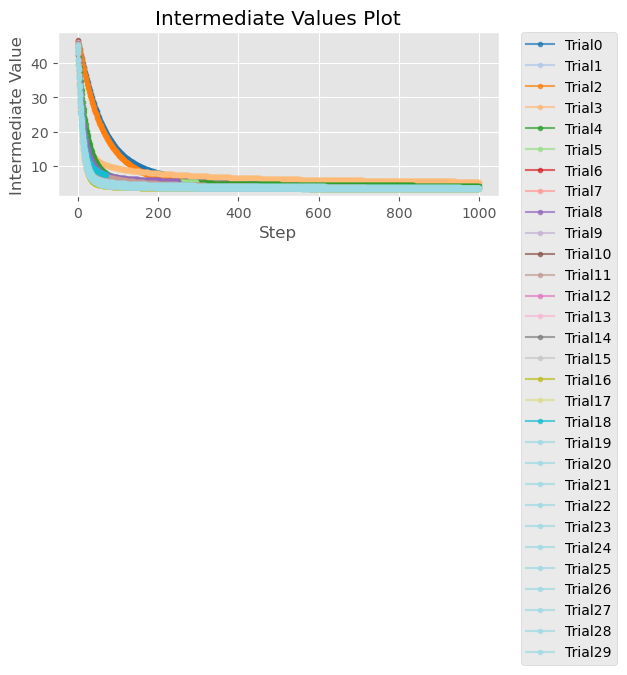

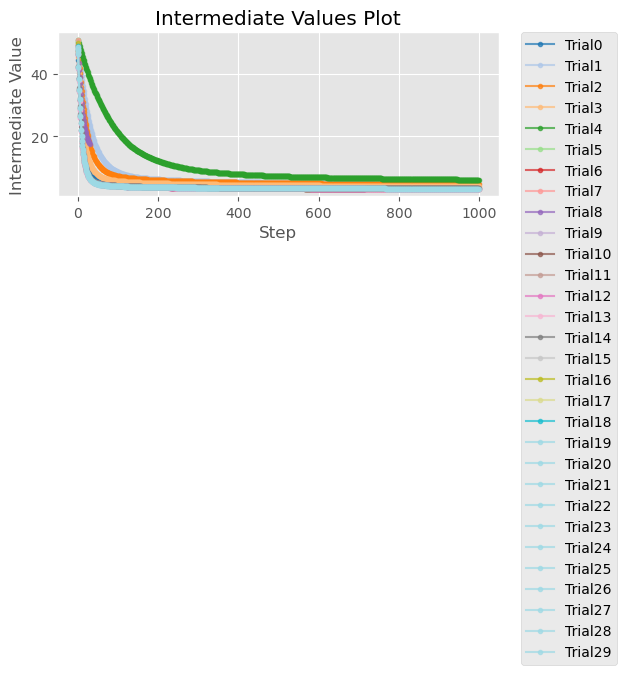

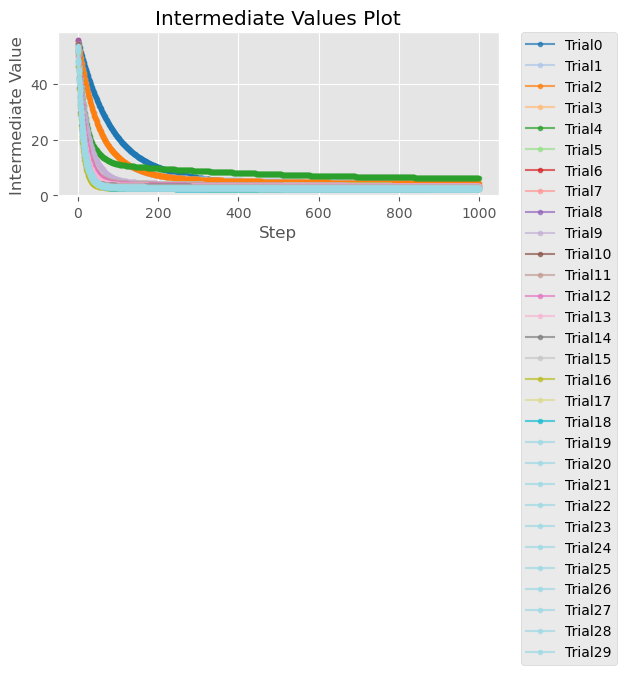

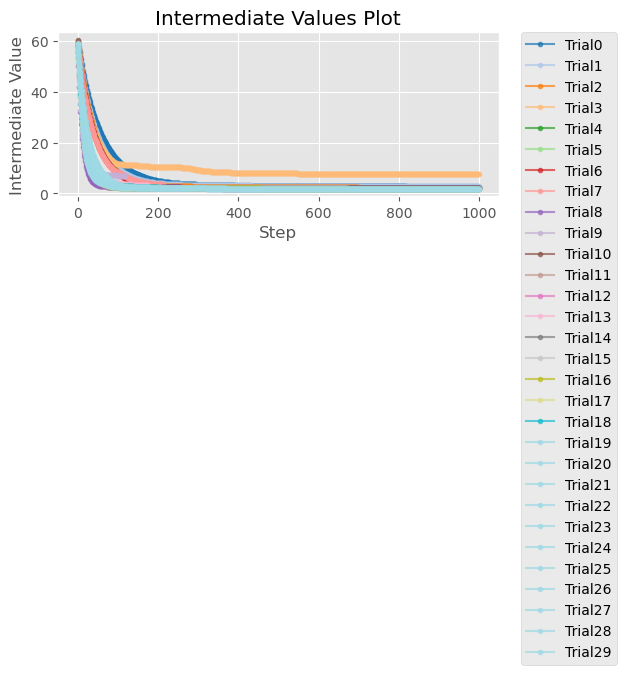

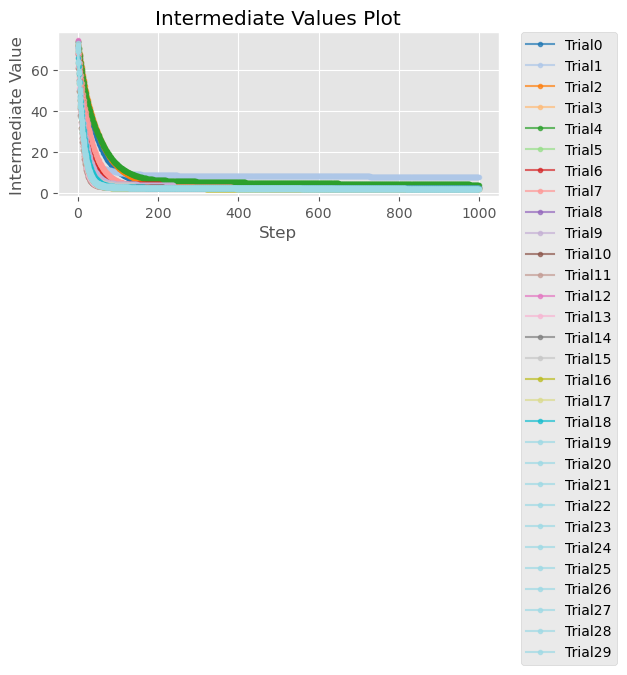

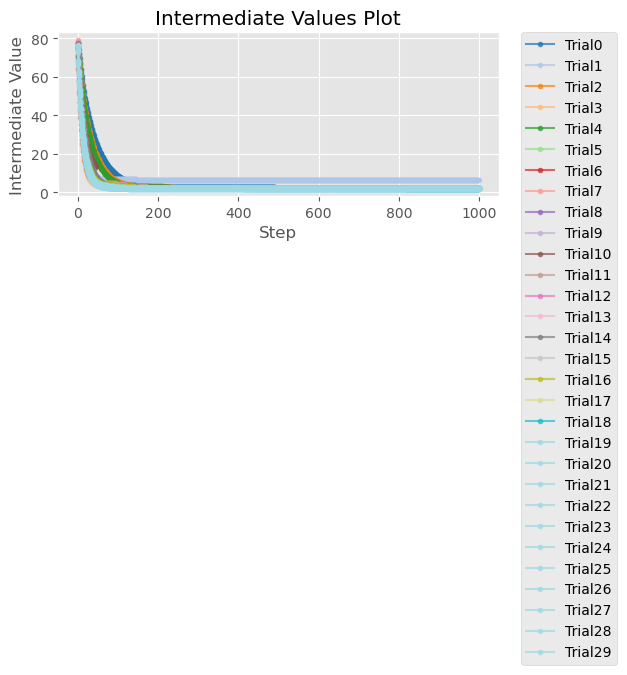

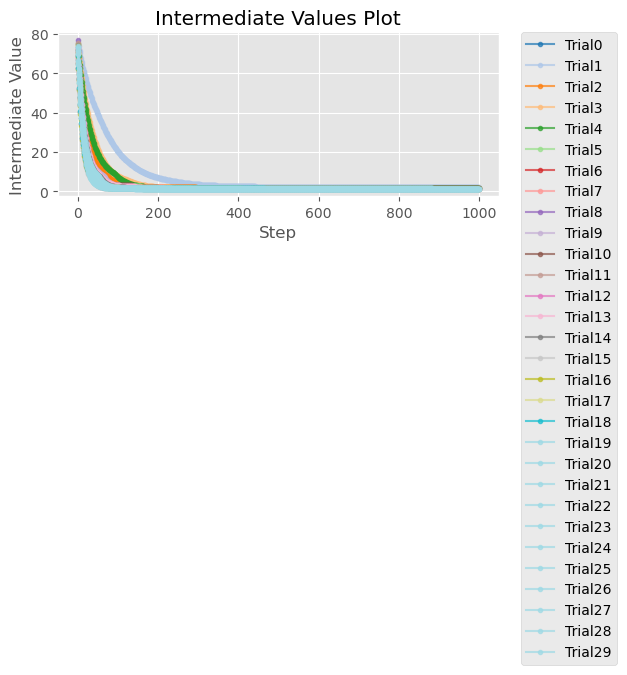

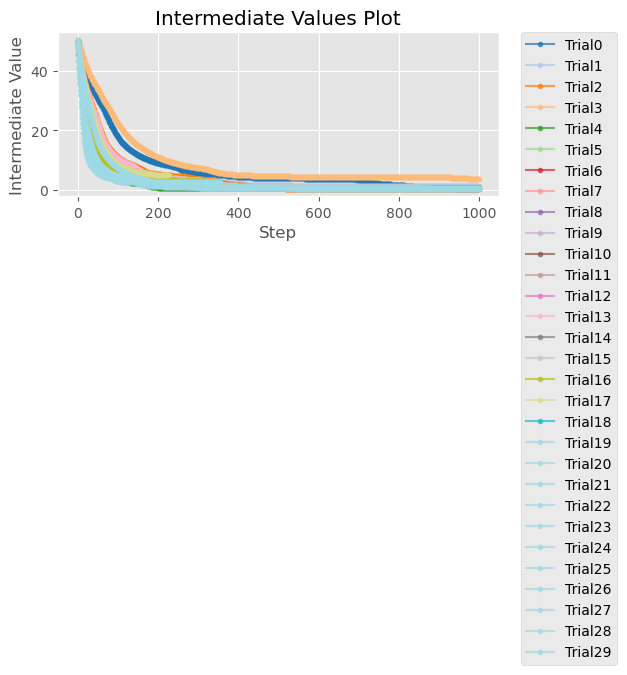

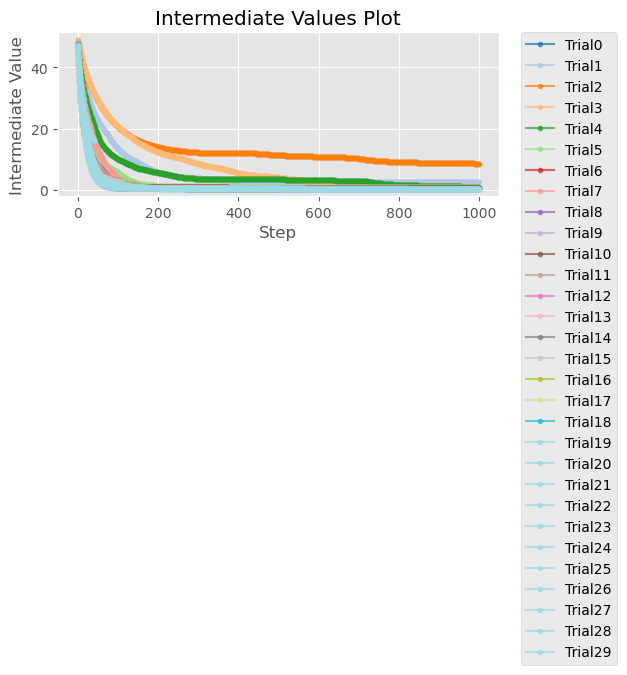

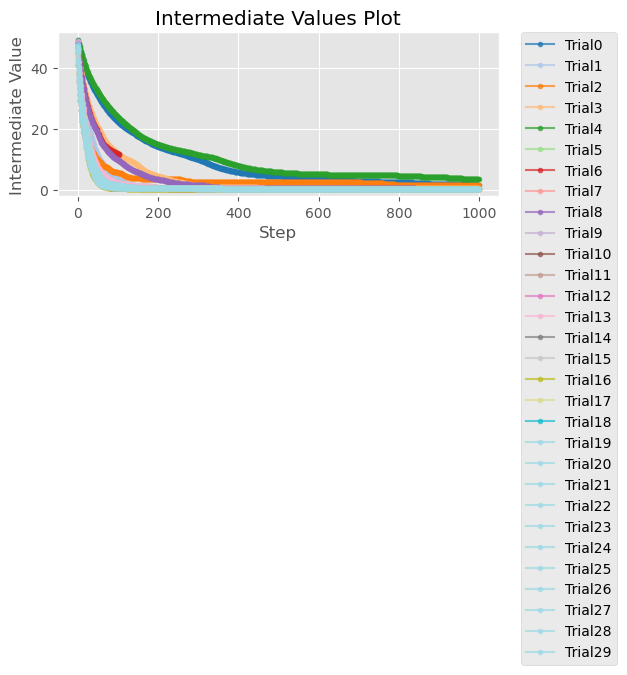

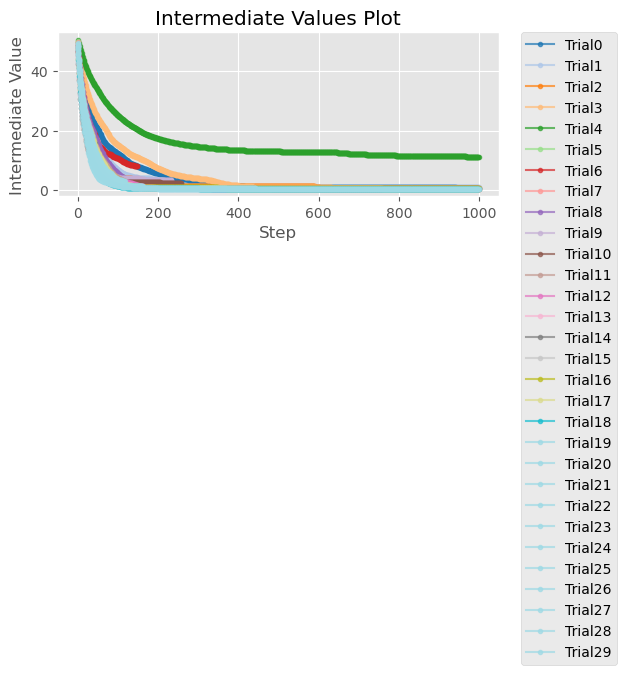

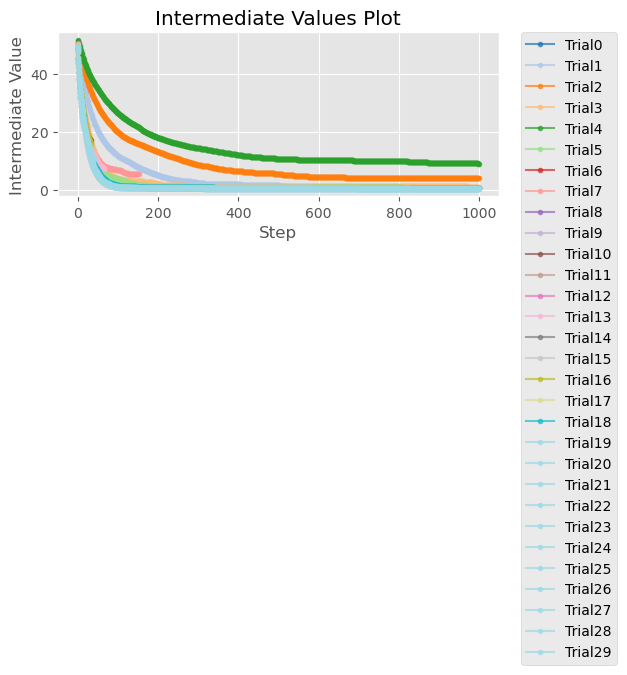

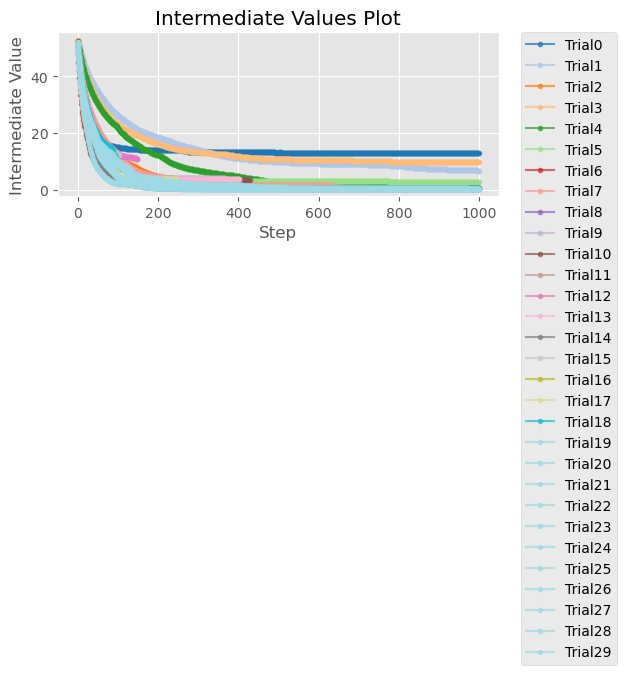

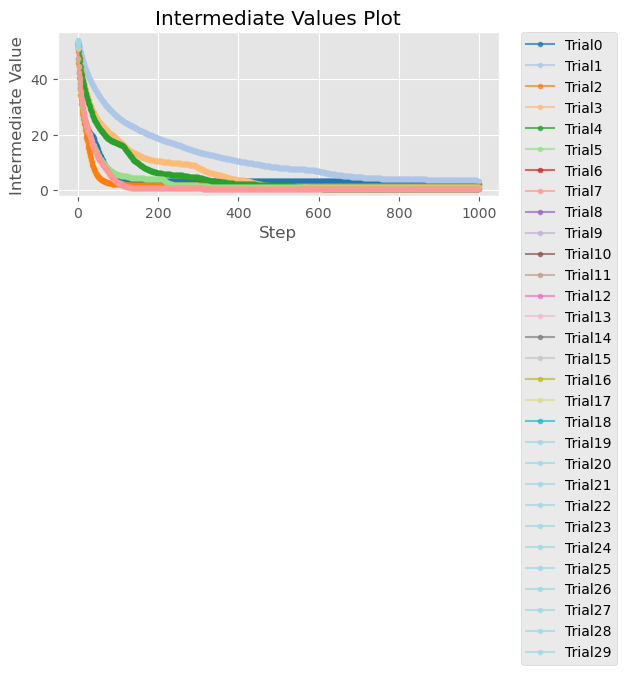

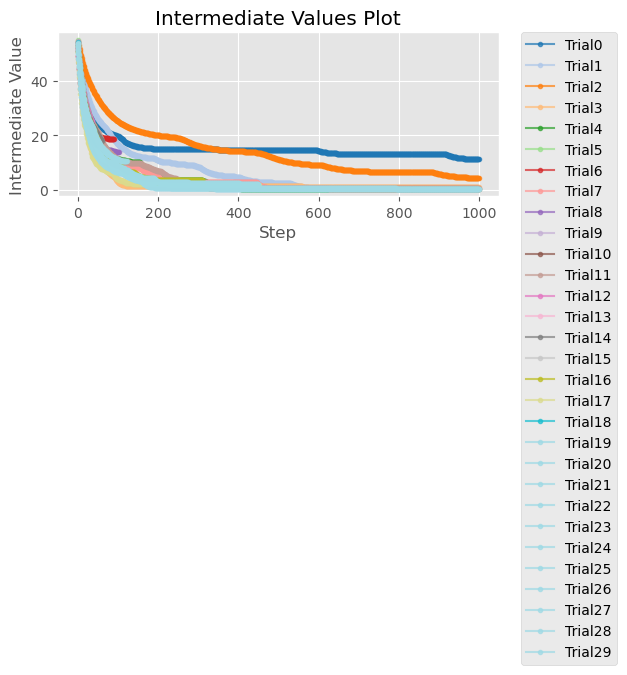

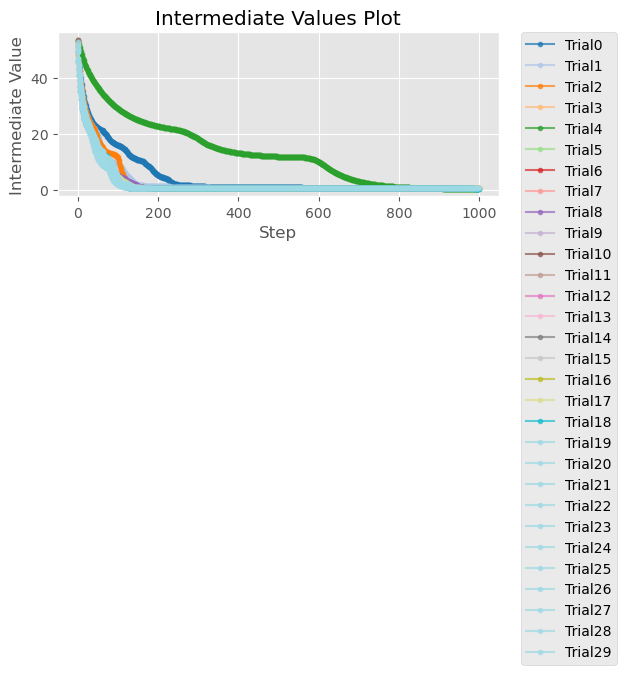

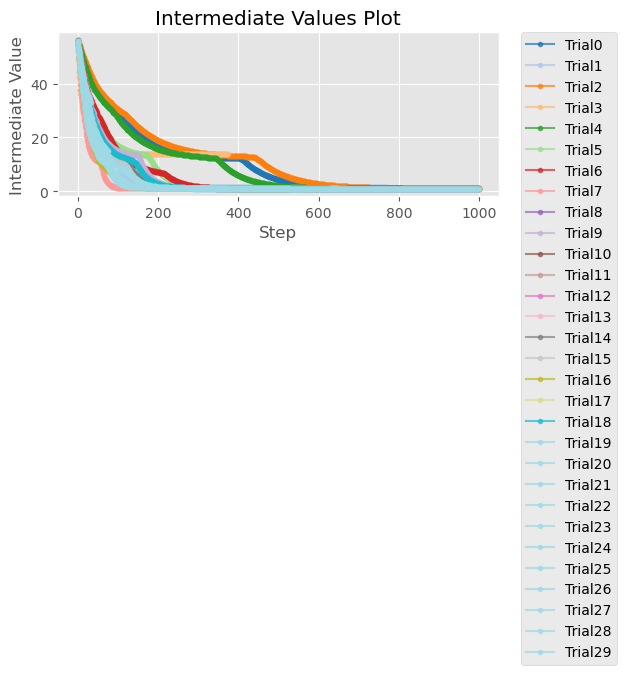

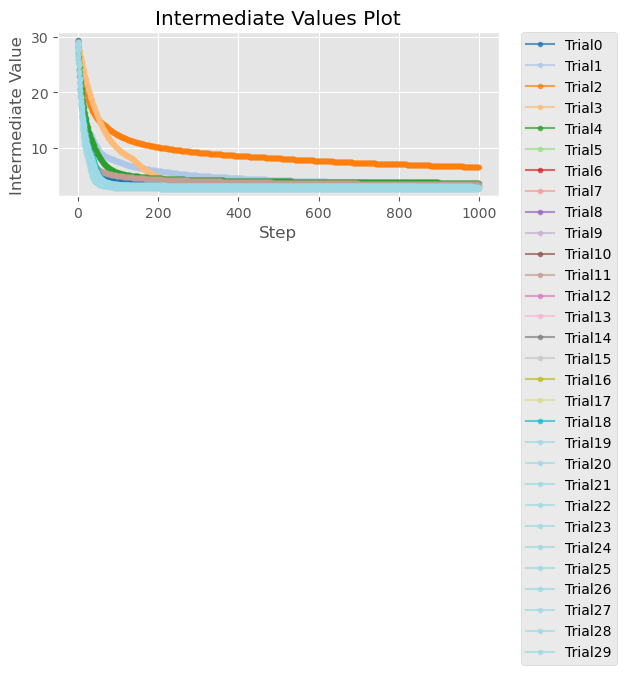

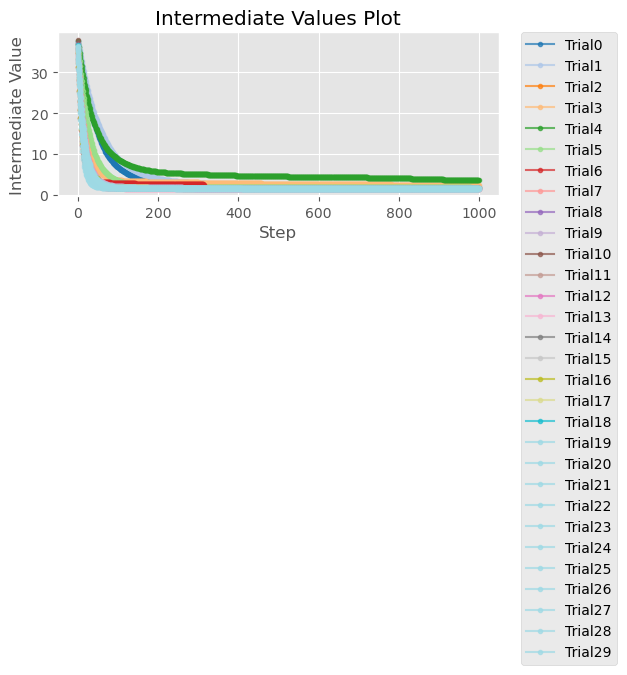

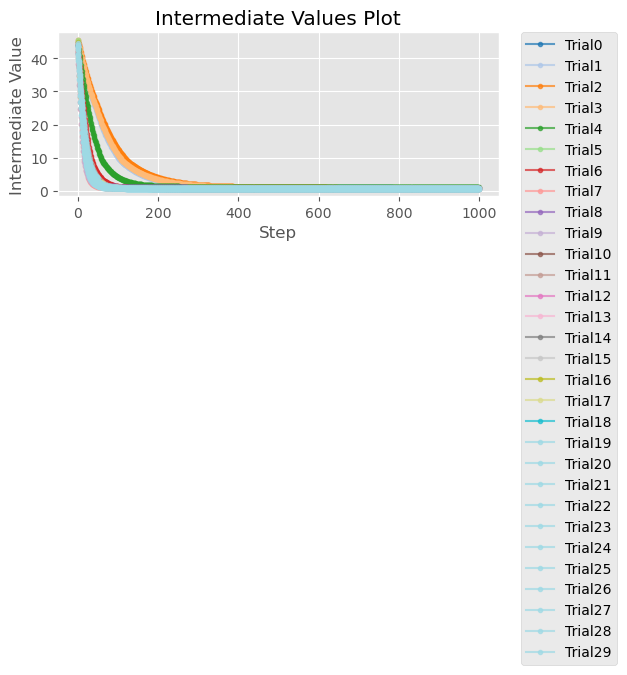

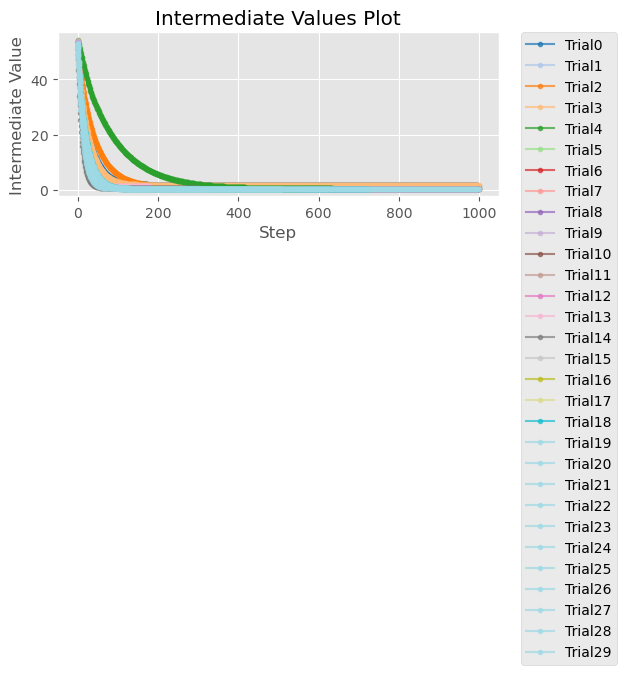

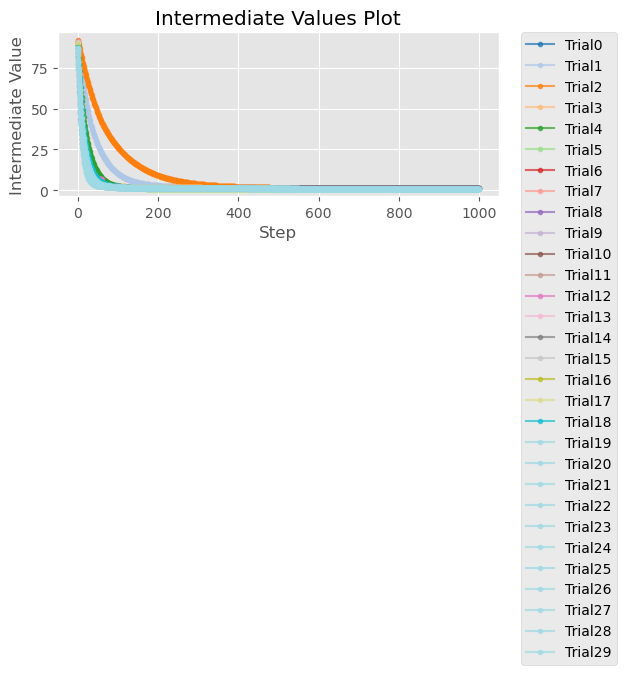

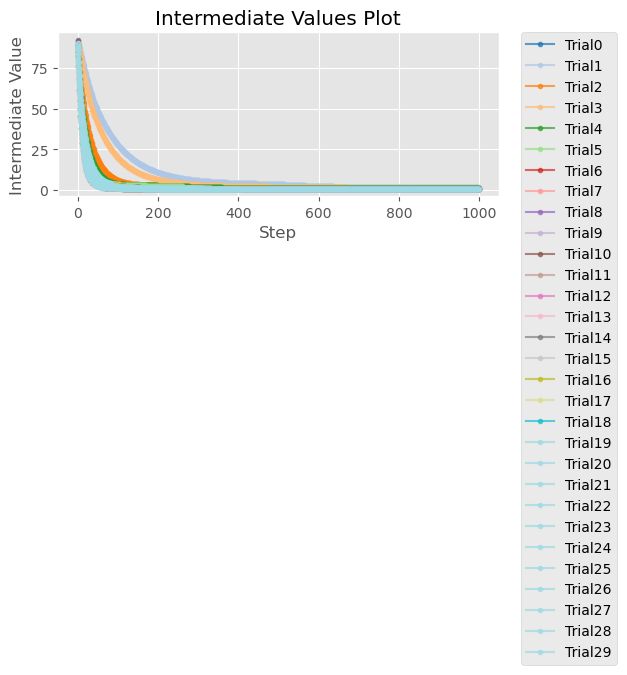

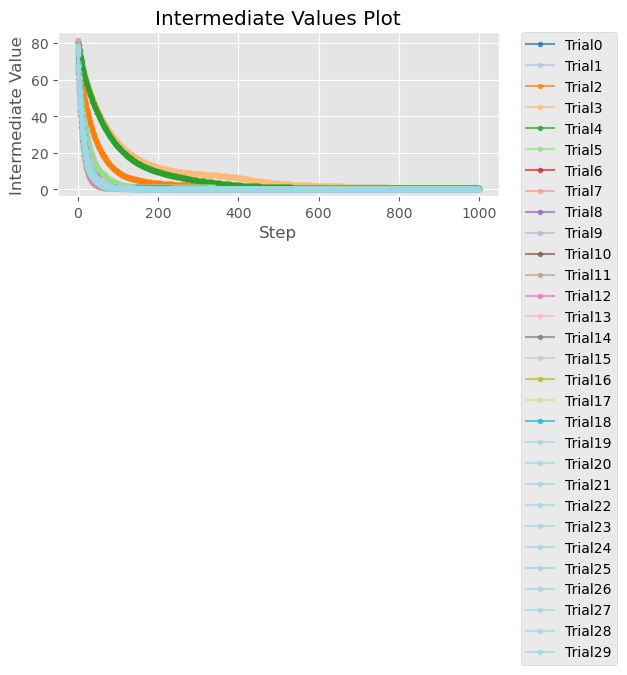

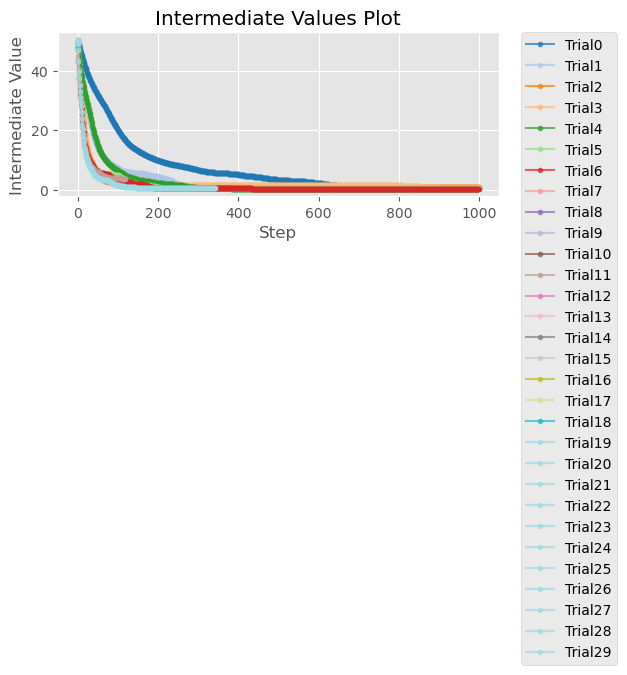

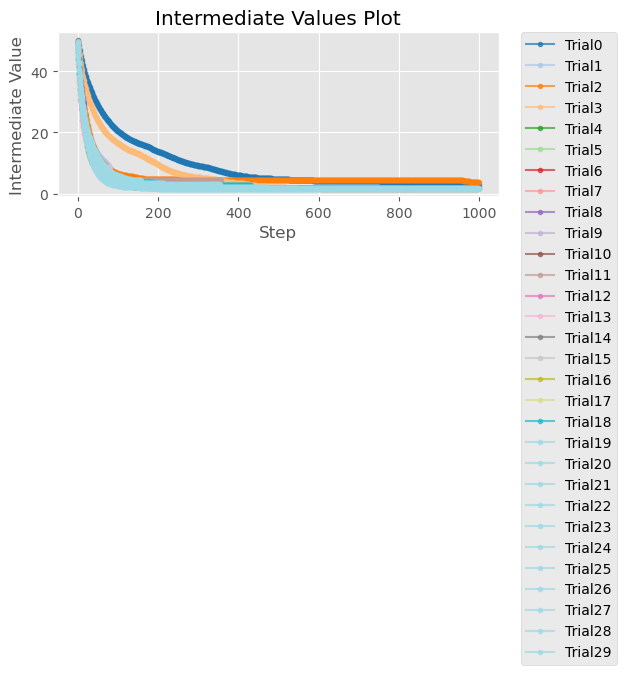

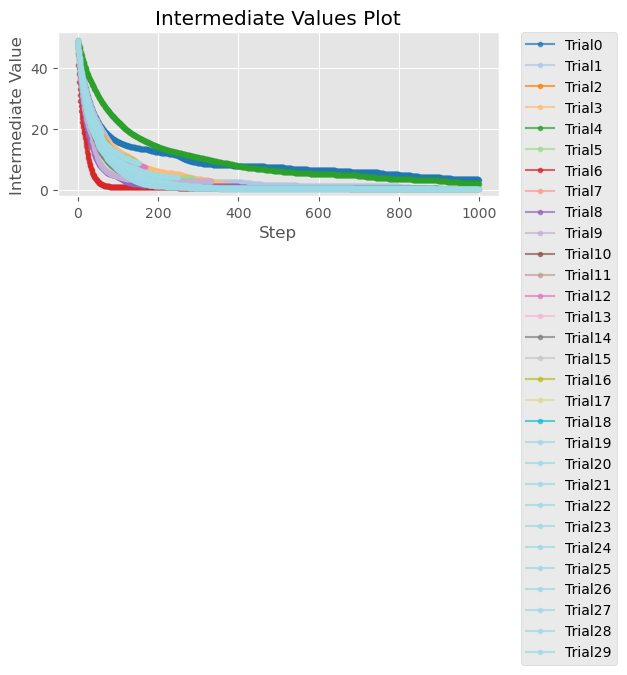

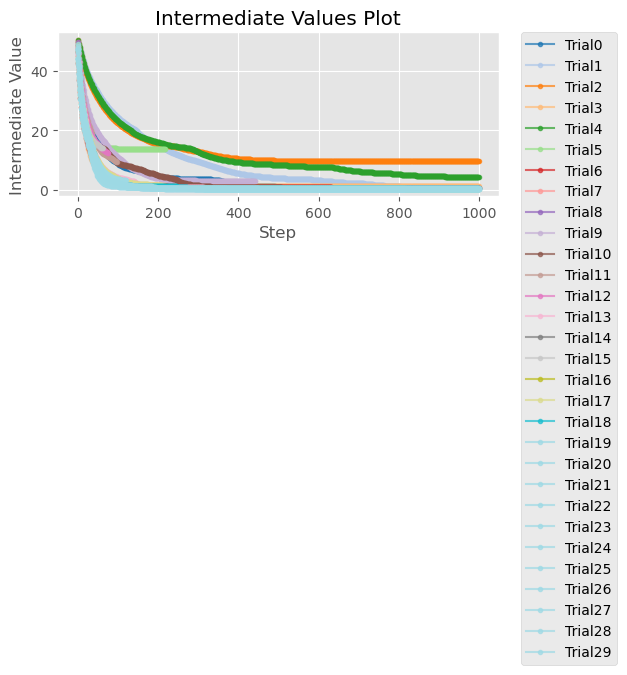

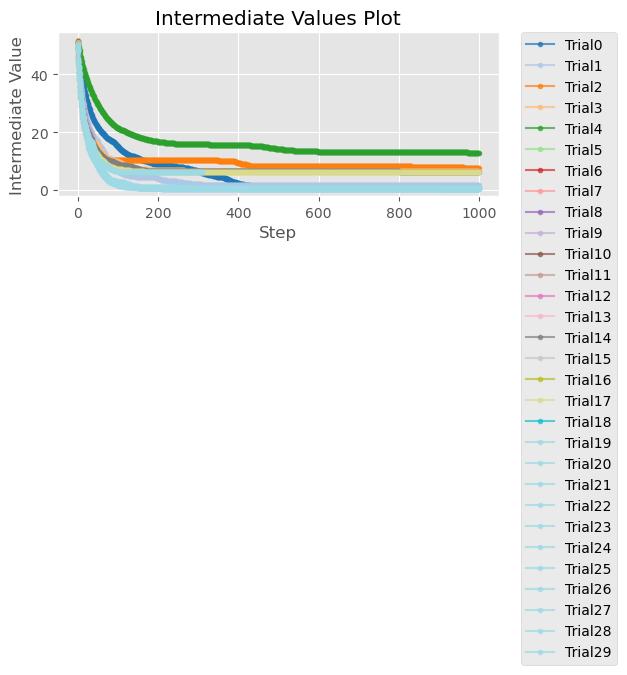

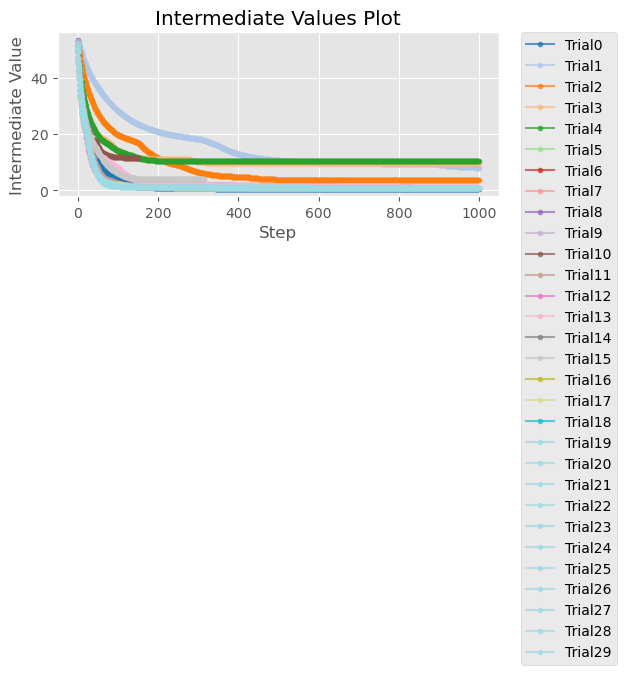

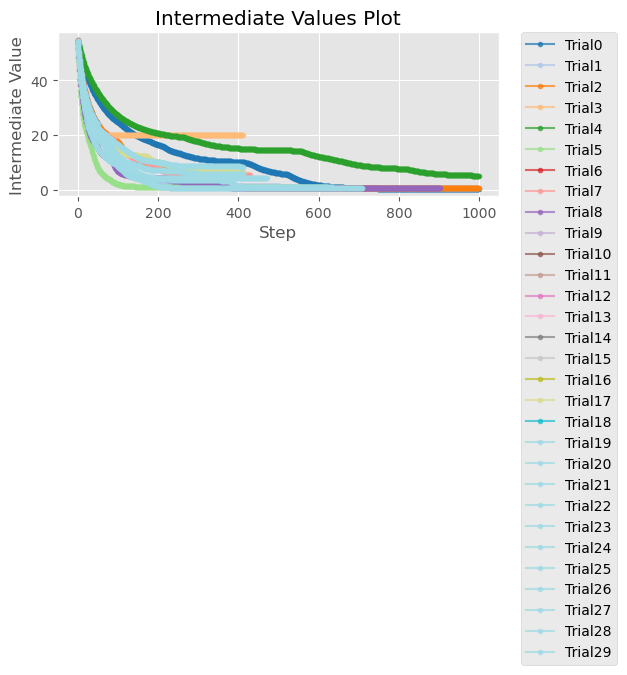

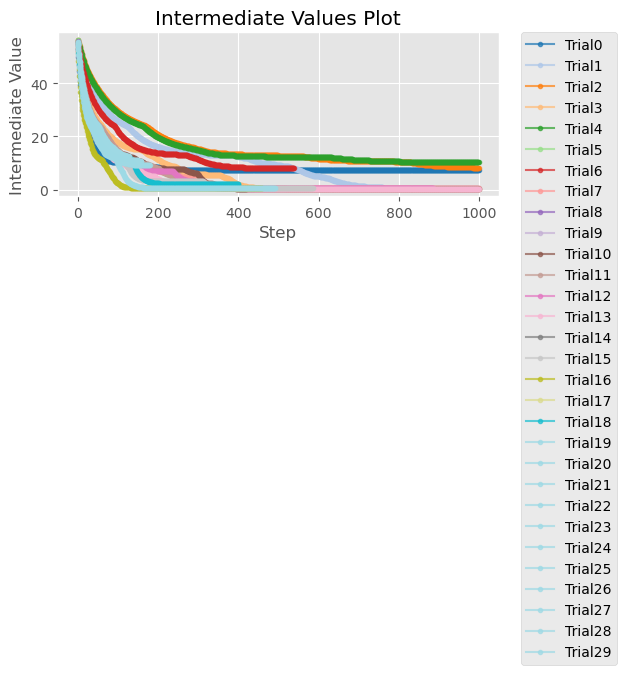

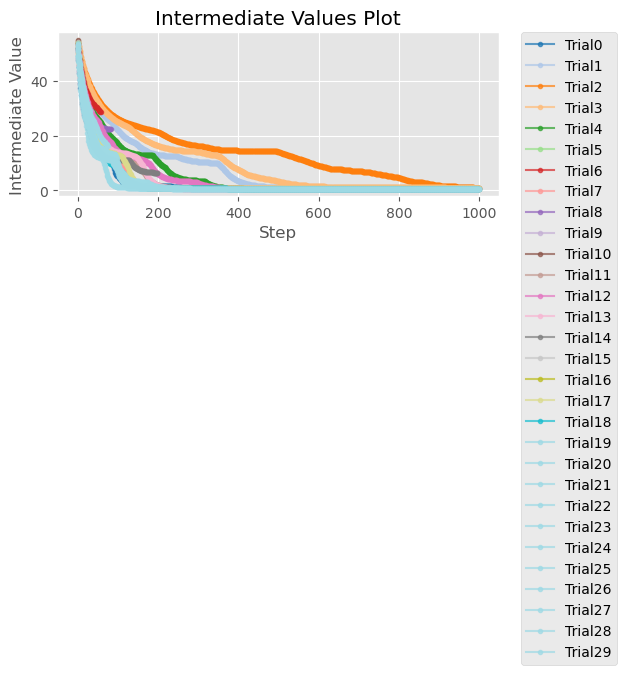

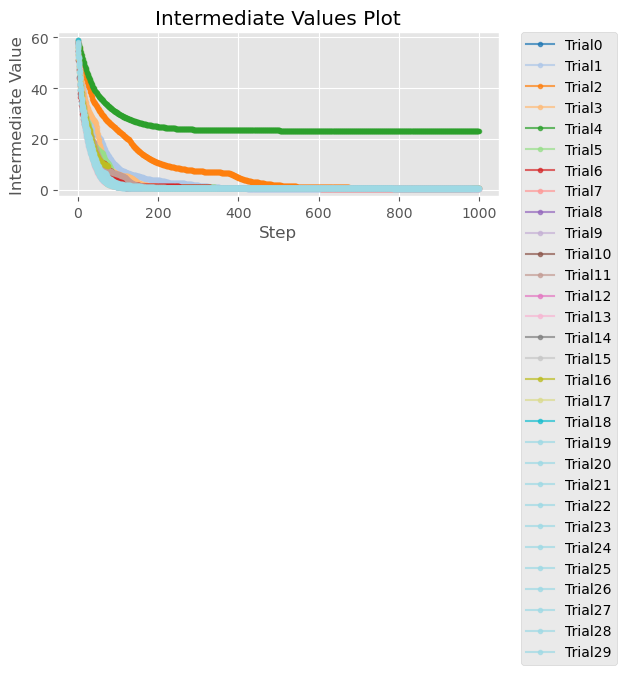

In [9]:
def sequential_optimization(x, y):
    for i, target in enumerate(y.columns):
        y_target = y[target]

        # 搜索超参数
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, x, y_target), n_trials=OPTUNA_ROUND)

        # 可视化
        ov.plot_optimization_history(study).write_image(f"{OUTPUT_PATH}/optimization_history_{target}.png")
        ov.plot_param_importances(study).write_image(f"{OUTPUT_PATH}/param_importances_{target}.png")
        ov.matplotlib.plot_intermediate_values(study).figure.savefig(f"{OUTPUT_PATH}/param_loss_{target}.png")

        # 使用最佳超参数训练模型
        best_params = study.best_trial.params
        train_data = lgb.Dataset(x, label=y_target)
        gbm_best = lgb.train(best_params, train_data, num_boost_round=TRAIN_ROUND)

        # 保存模型
        dump(gbm_best, f'./models/model_{i}.joblib')

sequential_optimization(X, Y)

## 模型推理

In [1]:
def predict_by_multi_targets(x, y):
    """
    使用保存的模型分开预测
    :param x: 测试集特征向量
    :param y: 训练集标签向量，用于提取名称
    """

    df_predictions = pd.DataFrame()

    for i in range(len(y.columns)):
        # 加载
        gbm_best_saved = load(f'{MODEL_SAVE_PATH}/model_{i}.joblib')

        # 预测
        predictions = gbm_best_saved.predict(x)

        # 存储
        df_predictions[f'target_{i}'] = predictions

    # 输出
    # df_predictions=df_predictions.astype('float16')
    df_predictions.insert(0, 'index', df_train['index'])
    df_predictions.columns = pd.read_csv(SUBMIT_PATH).columns
    df_predictions.to_csv(f'{OUTPUT_PATH}/predictions.csv', index=False)
    return df_predictions


predict_by_multi_targets(X_test, Y)

NameError: name 'X_test' is not defined